## Data Splitting, Preprocessing, Baseline Model


In [1]:
# Import necessary libraries


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, plot_confusion_matrix, roc_curve, auc, plot_roc_curve
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.dummy import DummyClassifier

In [4]:
# Load cleaned dataframe

In [5]:
df = pd.read_csv(
'./Data/Cleaned_Terry_Stops.csv')

In [6]:
df.head()

,Unnamed: 0,Subject Age Group,Stop Resolution,Weapon Type,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Arrest Flag,Frisk Flag
0,0,36 - 45,Field Contact,Unknown,White,Male,"DISTURBANCE, MISCELLANEOUS/OTHER",DISTURBANCE - OTHER,0,0
1,1,46 - 55,Field Contact,Unknown,White,Male,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0
2,2,26 - 35,Field Contact,No Weapons,White,Male,Unknown,Unknown,0,0
3,3,Unknown,Field Contact,Unknown,Black or African American,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0
4,4,26 - 35,Field Contact,Unknown,Unknown,Female,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0


In [7]:
df = df.drop(columns=['Unnamed: 0'])

In [8]:
df.shape

(2255432, 9)

In [9]:
# 2,255,432 rows are too huge. decease it to 250k rows

In [10]:
df = df.sample(n=250000, replace=False, weights=None, random_state=42)

# Perform a Dummy Classifier Model.
# Features: Subject Age Group, Stop Resolution, Weapon Type, Subject Perceived Race, Gender, Initial Call Type, Final Call Type, Frisk Flag
1. Define X and y
2. Train Test Split
3. Preprocessing
4. Modeling
5. Predict, Evaluate

In [11]:
X = df.drop('Arrest Flag', axis = 1)
y = df['Arrest Flag']

In [12]:
# Do (60, 20, 20) data split

In [13]:
X_train_touch, X_test, y_train_touch, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_touch, y_train_touch, test_size = 0.25, random_state= 42)

In [14]:
# create a mini-pipelines into our ColumnTransformer: categorical

subpipe_cat = Pipeline(steps = [
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])

# Create a column transformer
# passthrough leaves the other df columns unchanged.

CT = ColumnTransformer( transformers = [
    ('subpipe_cat', subpipe_cat, selector(dtype_include = object))
], remainder = 'passthrough')

In [15]:
## Use SMOTE to balance the minority class

In [16]:
## BRING IN OUR MODELING CLASS FROM BEFORE, COPIED THE BELOW CODES FROM LECTURE PIPELINE

In [17]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [18]:
# Dummy model pipeline
dum_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dum', DummyClassifier(strategy="most_frequent"))
])

In [19]:
dum_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9e5c0f1340>)])),
                ('dum', DummyClassifier(strategy='most_frequent'))])

In [20]:
dum_model_pipe.score(X_train, y_train)

0.9033666666666667

In [21]:
dum_model_pipe.score(X_val, y_val)

0.89974

In [23]:
# perform cross-validation on the dummy model

<AxesSubplot:title={'center':'CV Results for `dum` Model'}>

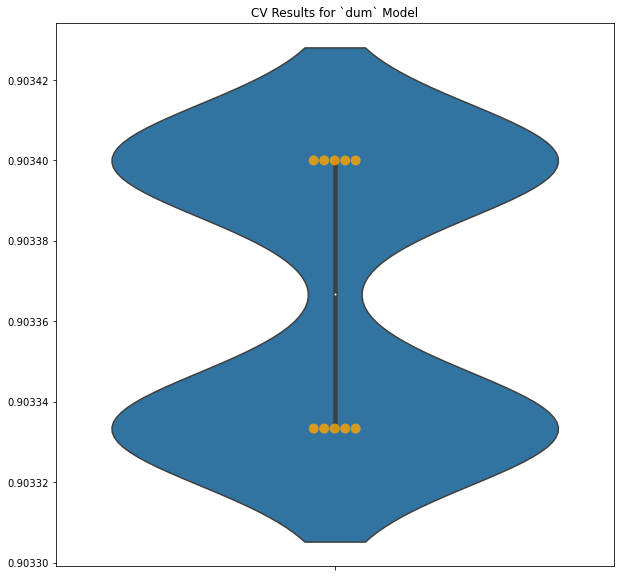

In [22]:
dum_pipe = ModelWithCV(
    dum_model_pipe,
    model_name='dum',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

dum_pipe.plot_cv(ax=ax)

In [24]:
dum_pipe.print_cv_summary()

CV Results for `dum` model:
            0.90337 ± 0.00003 accuracy
        


In [25]:
# Accuracy for traning set is 90.3% and 90% for validation set. With cross-validation, accuracy on traning set 
# is also 90.3%.

Dummy classifiers are mainly used for performance evaluation and can help to identify if a model is actually learning meaningful patterns or if the performance achieved is merely due to the class distribution in the dataset.

# First Logisitc Regression Model (FSM)

# Features: Subject Age Group, Stop Resolution, Weapon Type, Subject Perceived Race, Gender, Initial Call Type, Final Call Type, Frisk Flag

In [26]:
# Create FSM (First Simple Model)
## Use SMOTE to bring up the minority class to 33% (Minority), 66% (Majority)

logreg_model_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm', SMOTE(sampling_strategy=0.5, random_state = 42)), # setting minority half of majority
    ('fsm', LogisticRegression(random_state = 42))
])

In [27]:
logreg_model_pipe.fit(X_train, y_train) # this is taking a lot time because of OneHotEncoder and SMOTE

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9e5c0f1340>)])),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('fsm', LogisticRegression(random_state=42))])

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

<AxesSubplot:title={'center':'CV Results for `FSM` Model'}>

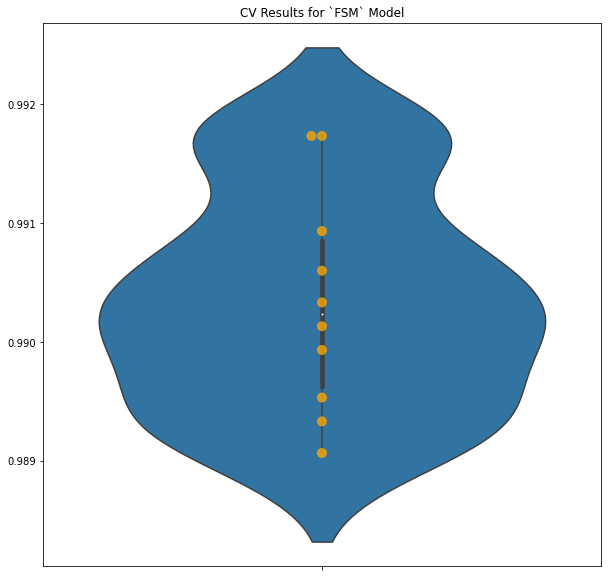

In [28]:
# Perform Cross-val on the training set with 10 folds
fsm_pipe = ModelWithCV(
    logreg_model_pipe,
    model_name='FSM',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

fsm_pipe.plot_cv(ax=ax)

In [29]:
fsm_pipe.print_cv_summary() # cross-validation training accuracy

CV Results for `FSM` model:
            0.99033 ± 0.00088 accuracy
        


In [30]:
logreg_model_pipe.score(X_val,y_val) # accuracy of the model with validation set

0.99046

## Observation: First logistic model has an accuracy of  99% on the training and 99% on the validation set. This model is actually pretty good.

In [35]:
# Further investigation on the validation set, get a classification report

In [32]:
y_val_pred = logreg_model_pipe.predict(X_val)

In [34]:
print (classification_report(y_val,y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     44987
           1       0.92      0.99      0.95      5013

    accuracy                           0.99     50000
   macro avg       0.96      0.99      0.97     50000
weighted avg       0.99      0.99      0.99     50000



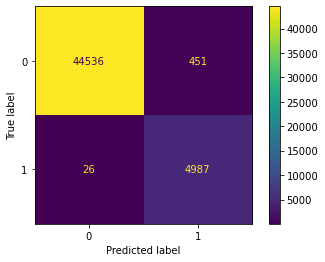

In [36]:
plot_confusion_matrix(logreg_model_pipe, X_val,y_val)

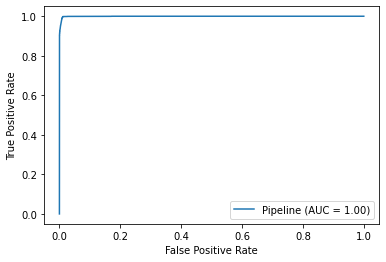

In [37]:
plot_roc_curve(logreg_model_pipe, X_val,y_val)

# This looks too good to be true.

    # How do I know how each feature contribute to the model?
    # Looking at coefficients, statsmodel pvalues
    # Reduce some features

In [40]:
# Leave it for now. Try to play around with DT

   ## 1st Baseline Decision Tree Model

In [41]:
# Use the same training and validation sets

In [43]:
# Create FDT (First Decision Tree)
## Same pipeline. change the model to dt

base_dtc_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm', SMOTE(sampling_strategy=0.5, random_state = 42)), # setting minority half of majority
    ('base_dtc', DecisionTreeClassifier(random_state = 42))
])

In [44]:
base_dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9e5c0f1340>)])),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('base_dtc', DecisionTreeClassifier(random_state=42))])

<AxesSubplot:title={'center':'CV Results for `base_dtc` Model'}>

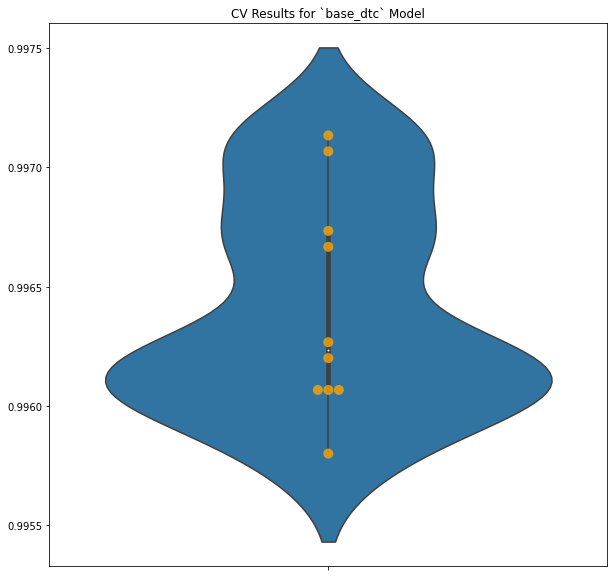

In [45]:
base_dtc = ModelWithCV(
    base_dtc_pipe,
    model_name='base_dtc',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

base_dtc.plot_cv(ax=ax)

In [48]:
base_dtc.print_cv_summary() # accuracy of the model on training set

CV Results for `base_dtc` model:
            0.99641 ± 0.00044 accuracy
        


In [50]:
base_dtc_pipe.score(X_val, y_val) # accuracy of the model on validation set

0.9973

In [51]:
## This tree is very good.. look into more info

In [53]:
y_val_pred_base_dtc = base_dtc_pipe.predict(X_val)

In [54]:
print (classification_report(y_val,y_val_pred_base_dtc)) # see how good the mdoel predict compared to validation targets

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44987
           1       0.98      0.99      0.99      5013

    accuracy                           1.00     50000
   macro avg       0.99      1.00      0.99     50000
weighted avg       1.00      1.00      1.00     50000



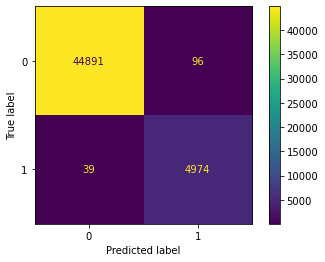

In [55]:
plot_confusion_matrix(base_dtc_pipe, X_val, y_val)

In [56]:
## wow this base decision tree is even better than the base logistic regression model

In [57]:
## check ROC-AUC

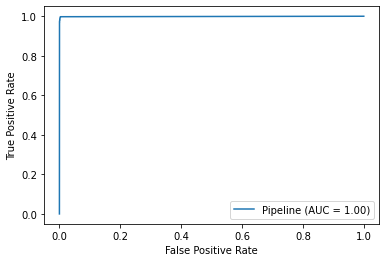

In [58]:
plot_roc_curve(base_dtc_pipe, X_val, y_val)

In [59]:
## WHAT IS THIS??? 1???

# TO GOOD TO BE TRUE

In [62]:
# try gripsearch on decision tree

In [65]:

parameters = {'base_dtc__criterion': ['gini', 'entropy'],
          'base_dtc__min_samples_leaf': [10, 15, 20],
          'sm__k_neighbors': [9, 11, 13]}

gs = GridSearchCV(estimator= base_dtc_pipe,
                 param_grid=parameters,
                 cv=5,
                 verbose=2)

In [66]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total= 2.7min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total= 3.8min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total= 2.4min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total= 2.5min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total= 3.1min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=11, total= 4.4min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=11, total= 3.7min
[CV] base_dtc__

KeyboardInterrupt: 

In [ ]:
gs.best_params_